# Install and import dependencies

In [58]:
!pip install yfinance

In [59]:
import numpy as np
import pandas as pd

import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Feature Engineering: Calculating Yearly S&P 500 Returns

## Introduction

In this section of our project, we focus on feature engineering, specifically on deriving the yearly returns of the S&P 500 index. These returns will serve as the dependent variable in our analysis, helping us assess the predictive power of financial metrics from preceding years on future stock performance relative to the market.

## Objective

The objective of this feature engineering phase is to:
- Calculate the yearly returns (percentage price change) for the S&P 500 for each year from 2015 to 2019.
- Use these returns as the dependent variable to analyze the correlation between past financial indicators and the subsequent year's stock performance relative to the S&P 500.

## Data Acquisition

We will use the `yfinance` library to download historical data for the S&P 500 index (`^GSPC`). The period of interest spans from December 31, 2014, to December 31, 2019, allowing us to calculate annual returns that are synchronized with the financial year-ends of the stocks under study.

## Methodology

1. **Downloading Data**: Fetch the historical adjusted close prices for the S&P 500 from Yahoo Finance using the `yfinance` library.
2. **Annual Returns Calculation**:
   - Resample the data to obtain the closing price on the last trading day of each year.
   - Calculate the percentage change in these closing prices year-over-year to derive the annual returns.
3. **Alignment with Financial Metrics**:
   - Align these annual returns with the financial data from the end of each previous year (2014-2018). This alignment ensures that each return value from 2015 to 2019 corresponds to financial metrics from the end of 2014 to 2018, respectively.

## Expected Outcomes

This feature engineering step will provide us with a well-defined dependent variable, representing the S&P 500 yearly returns. By correlating these returns with the financial metrics of stocks from the previous years, we aim to uncover significant predictors of stock performance relative to the broader market.

## Conclusion

The successful calculation and integration of yearly S&P 500 returns into our dataset are crucial for subsequent predictive modeling. This step forms the backbone of our analysis, enabling us to rigorously test our hypothesis that prior financial metrics can serve as reliable indicators of future market outperformance.



#### Fetch the S&P 500 data

Note: The yfinance library does use adjusted closing prices from Yahoo Finance, which accounts for corporate actions like dividends and stock splits.

In [60]:
# Define the ticker symbol for the S&P 500
ticker_symbol = "^GSPC"

# Set the start and end dates for each year-end closing from 2014 to 2018
start_date = "2014-12-31"
end_date = "2023-12-31"

# Download the historical data
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Calculate the yearly close by resampling to annual frequency at year-end
# The 'Y' frequency here will ensure that it picks the last trading day of each calendar year
yearly_data = data['Adj Close'].resample('YE').last()

# Calculate the yearly returns
sp_yearly_returns = yearly_data.pct_change().dropna() * 100

# The yearly returns should not be offset by -1 year in the index for your needs,
# because we want the financial year data of 2014 (ending in 2014) to predict the gains in 2015, and so on
# The index should just be adjusted to correspond to the years where the returns are applicable
sp_yearly_returns.index = sp_yearly_returns.index.year

# Print the yearly returns
sp_yearly_returns



[*********************100%%**********************]  1 of 1 completed


Date
2015    -0.726600
2016     9.535023
2017    19.419966
2018    -6.237260
2019    28.878070
2020    16.258923
2021    26.892739
2022   -19.442827
2023    24.230501
Name: Adj Close, dtype: float64

In [61]:
type(sp_yearly_returns)

pandas.core.series.Series

## Calculation of Stock Alphas Relative to S&P 500

### Introduction

In this section, we will calculate the alpha for each stock in our dataset for the years 2015 to 2018. Alpha measures the performance of a stock relative to a benchmark, which in this case is the S&P 500. A positive alpha indicates that the stock has outperformed the benchmark on a risk-adjusted basis, while a negative alpha indicates underperformance.

### Objective

The objective of this analysis is to determine how much each stock over- or under-performed relative to the S&P 500. This insight can help identify stocks that might offer better returns compared to the market.

### Methodology

We calculate alpha using the formula:
alpha = {Stock Return} - {S&P 500 Return}
Where:
- **Stock Return** is the percentage price variation of the stock for the year.
- **S&P 500 Return** is the return of the S&P 500 index for the corresponding year.

### Execution

We will add a new column for alpha for each year from 2014 to 2018, using the yearly returns of the S&P 500 and the stock's performance from the previous year's dataset.


In [62]:
# Load datasets
data_2014 = pd.read_csv('processed_data/clean_df_2014.csv')
data_2015 = pd.read_csv('processed_data/clean_df_2015.csv')
data_2016 = pd.read_csv('processed_data/clean_df_2016.csv')
data_2017 = pd.read_csv('processed_data/clean_df_2017.csv')
data_2018 = pd.read_csv('processed_data/clean_df_2018.csv')

# Add alpha calculation for each dataset
datasets = [data_2014, data_2015, data_2016, data_2017, data_2018]
year_start = 2015

def create_alphas(datasets, yearly_returns, year_start):
    """
    Updates the datasets with alpha values computed as the difference between 
    the price variation and yearly returns of the S&P 500.

    Parameters:
    - datasets: List of pandas DataFrames containing the yearly data.
    - yearly_returns: Dictionary containing yearly returns of the S&P 500.
    - year_start: The starting year for the datasets.
    
    Returns:
    - updated_datasets: List of updated DataFrames with alpha columns added.
    """
    updated_datasets = []

    for i, data in enumerate(datasets):
        price_var_col = f'{year_start + i} PRICE VAR [%]'
        alpha_col = f'Alpha_{year_start + i}'
        
        if price_var_col in data.columns:
            data[alpha_col] = data[price_var_col] - yearly_returns[year_start + i]
        
        # Append the updated DataFrame to the list
        updated_datasets.append(data)
        
        # Print the updated DataFrame to verify the new alpha column
        print(data[['Symbol', price_var_col, alpha_col]].head(1))
    
    return updated_datasets

# Example usage
datasets = [data_2014, data_2015, data_2016, data_2017, data_2018]

updated_datasets = create_alphas(datasets, sp_yearly_returns, year_start)

  Symbol  2015 PRICE VAR [%]  Alpha_2015
0     PG           -9.323276   -8.596676
  Symbol  2016 PRICE VAR [%]  Alpha_2016
0     PG           10.809451    1.274429
  Symbol  2017 PRICE VAR [%]  Alpha_2017
0     PG           12.532463   -6.887503
  Symbol  2018 PRICE VAR [%]  Alpha_2018
0     PG            4.975151   11.212411
  Symbol  2019 PRICE VAR [%]  Alpha_2019
0  CMCSA           32.794573    3.916503


### Let's check everything went well

In [63]:
f'Alpha first stock in the dataset 2014: {data_2014['2015 PRICE VAR [%]'][0]-sp_yearly_returns[2015]}',\
f'Alpha first stock in the dataset 2015: {data_2015['2016 PRICE VAR [%]'][0]-sp_yearly_returns[2016]}',\
f'Alpha first stock in the dataset 2016: {data_2016['2017 PRICE VAR [%]'][0]-sp_yearly_returns[2017]}',\
f'Alpha first stock in the dataset 2017: {data_2017['2018 PRICE VAR [%]'][0]-sp_yearly_returns[2018]}',\
f'Alpha first stock in the dataset 2018: {data_2018['2019 PRICE VAR [%]'][0]-sp_yearly_returns[2019]}'

('Alpha first stock in the dataset 2014: -8.596676276863182',
 'Alpha first stock in the dataset 2015: 1.2744285584534278',
 'Alpha first stock in the dataset 2016: -6.887502589116078',
 'Alpha first stock in the dataset 2017: 11.212410700737287',
 'Alpha first stock in the dataset 2018: 3.9165031818058154')

It looks like everything is correct, now it would be interesting to create another dependent variables for the gains of 3 and 5 years for future modeling. But we could come back to do it once we finish the first modeling.

## Visualizing Stocks Outperforming the S&P 500

### Let's visualize our findings using the dependent variable

We will visualize the stocks that have outperformed the S&P 500 by year. Specifically, we will look at the top and bottom performers in terms of alpha, which measures the performance of each stock relative to the S&P 500. 

### Function Definition

The `plot_alphas` function is designed to plot the alphas for a given year, highlighting the top and bottom performers. The function takes the following parameters:
- `data`: The dataset containing the stock information and calculated alphas.
- `year`: The year for which to plot the alphas.
- `top_n`: The number of top-performing stocks to display (default is 10).
- `bottom_n`: The number of bottom-performing stocks to display (default is 10).

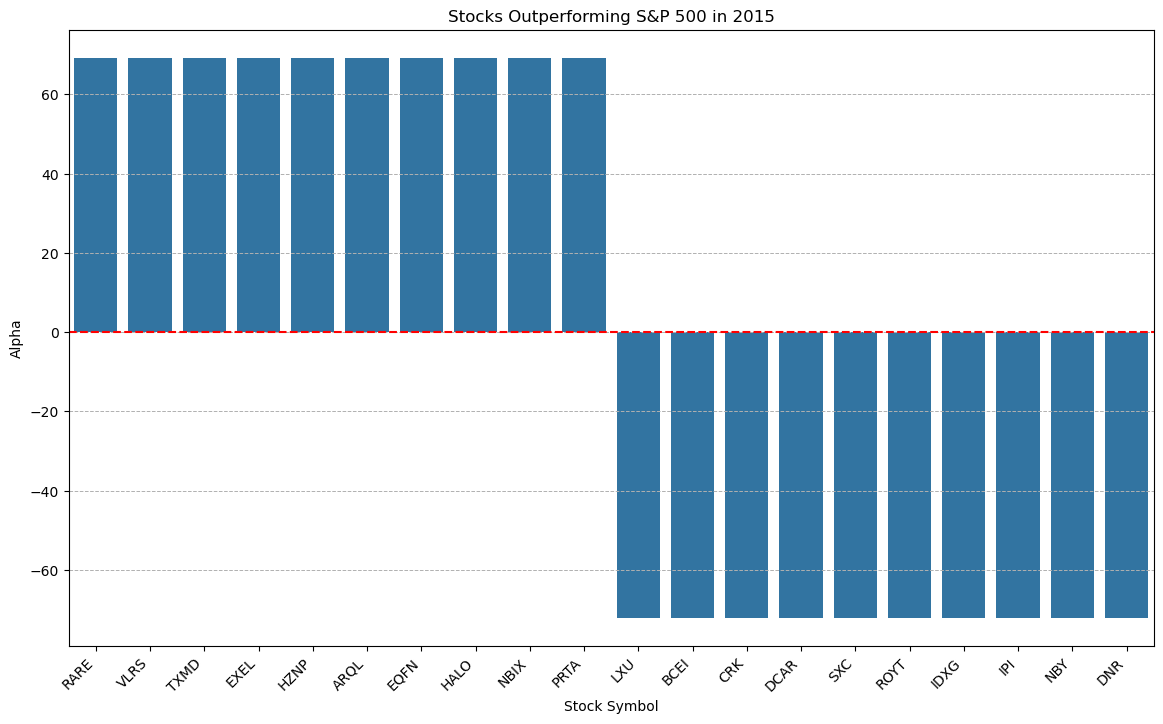

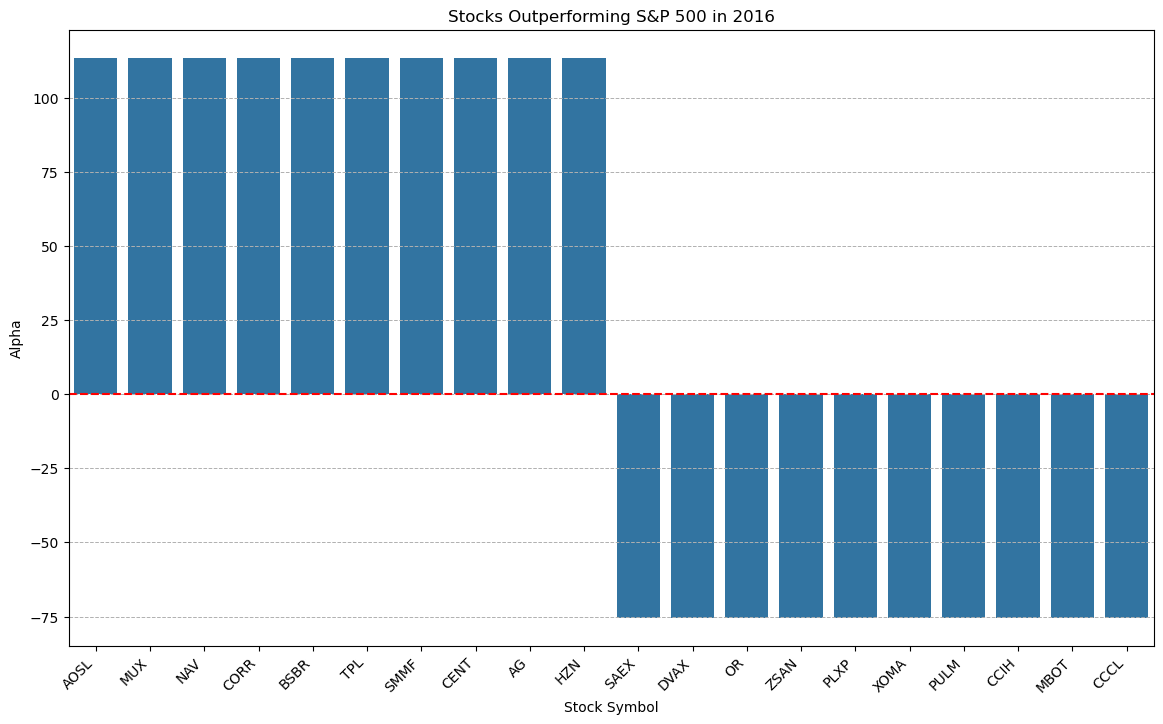

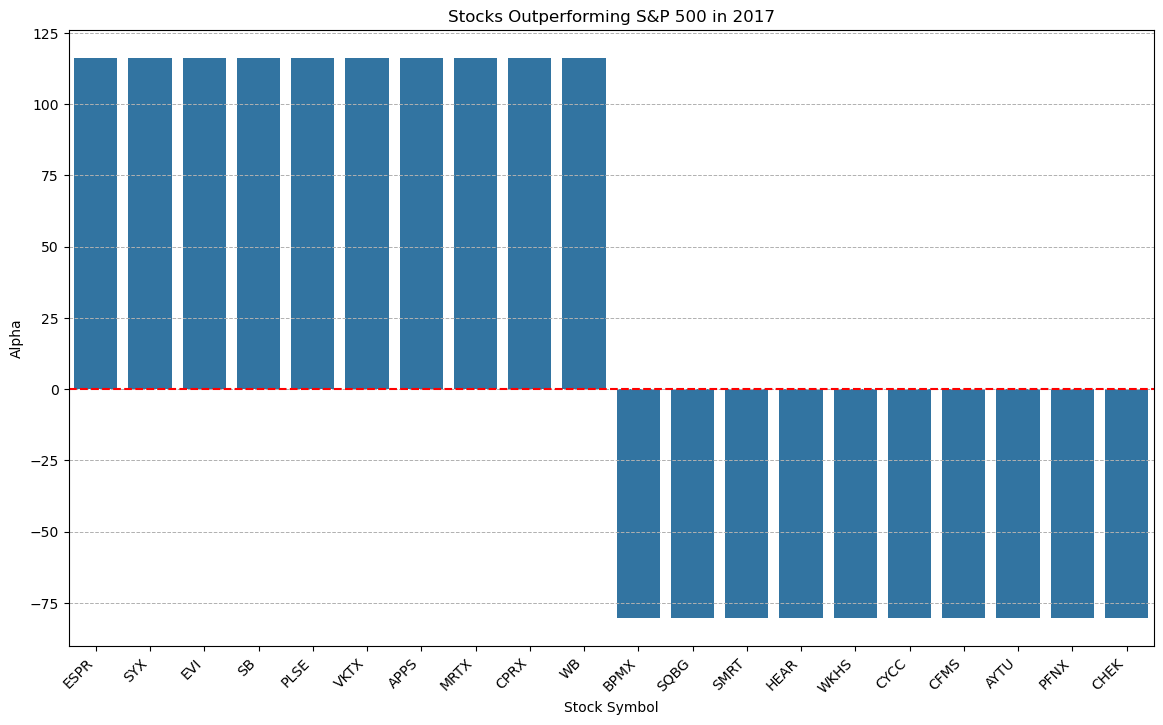

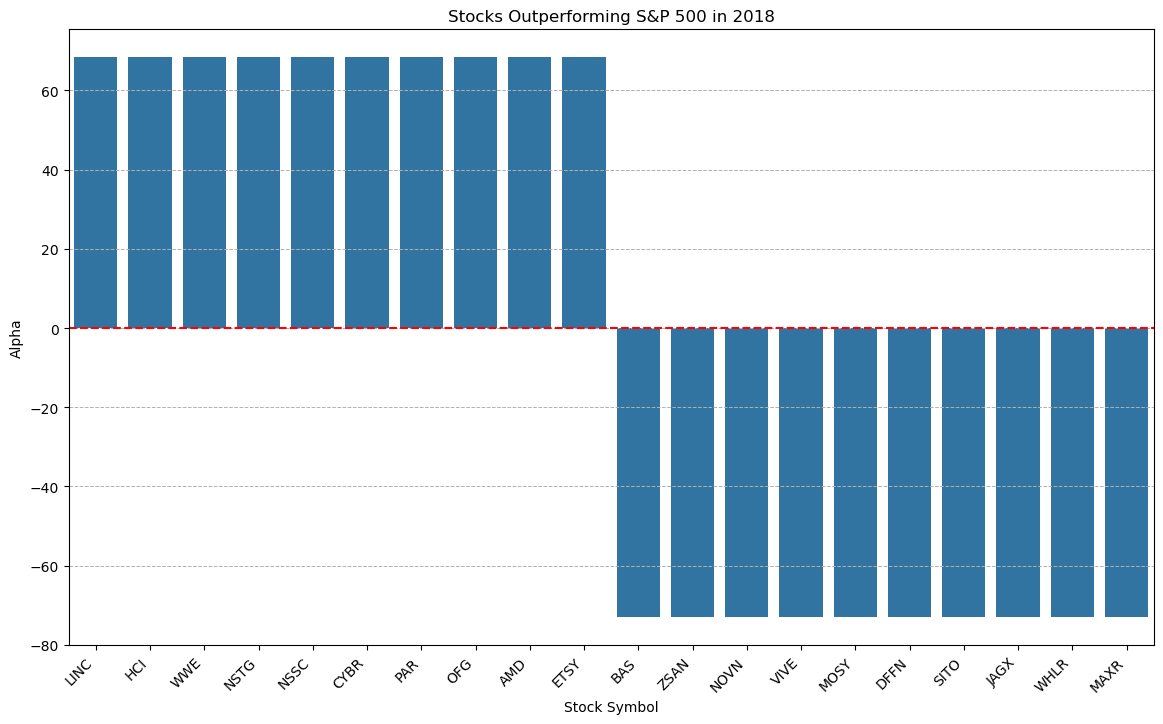

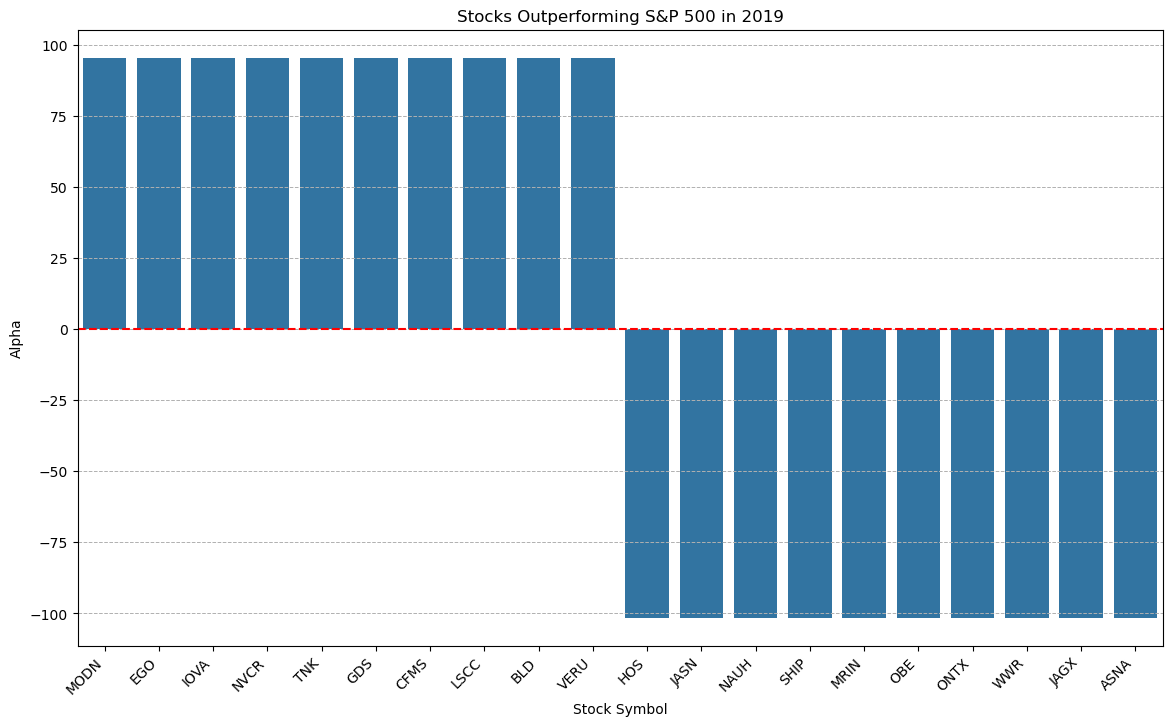

In [64]:
# Function to plot alphas for a given year with parameter for top and bottom records
def plot_alphas(data, year, top_n=10, bottom_n=10):
    alpha_col = f'Alpha_{year}'
    plt.figure(figsize=(14, 8))
    
    # Sort data by alpha
    data_sorted = data.sort_values(by=alpha_col, ascending=False)
    
    # Select top and bottom performers
    top_bottom = pd.concat([data_sorted.head(top_n), data_sorted.tail(bottom_n)])
    
    sns.barplot(x='Symbol', y=alpha_col, data=top_bottom)
    plt.title(f'Stocks Outperforming S&P 500 in {year}')
    plt.xlabel('Stock Symbol')
    plt.ylabel('Alpha')
    plt.axhline(0, color='red', linestyle='--')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', linewidth=0.7)
    plt.show()

# Plot alphas for each year with default top 10 and bottom 10
plot_alphas(data_2014, 2015, top_n=10, bottom_n=10)
plot_alphas(data_2015, 2016, top_n=10, bottom_n=10)
plot_alphas(data_2016, 2017, top_n=10, bottom_n=10)
plot_alphas(data_2017, 2018, top_n=10, bottom_n=10)
plot_alphas(data_2018, 2019, top_n=10, bottom_n=10)

In [65]:
symbols_of_interest = ['VLRS', 'RARE']
filtered_data = data_2014[data_2014['Symbol'].isin(symbols_of_interest)][['Alpha_2015', '2015 PRICE VAR [%]']]
print(filtered_data.head())


      Alpha_2015  2015 PRICE VAR [%]
621    69.172049           68.445449
1754   69.172049           68.445449


#### This looks weird, Why we have a lot of different stocks with the same price variation? let's see!

In [66]:
data_2014.shape

(3786, 207)

In [67]:
data_2014['2015 PRICE VAR [%]'].nunique()

3550

We have a lot of stocks with the same performance could be that correct? i do not think so.

In [68]:
# Get the non-unique values in the '2015 PRICE VAR [%]' column
non_unique_values = data_2014['2015 PRICE VAR [%]'][data_2014['2015 PRICE VAR [%]'].duplicated()].unique()

# Filter the dataset for those non-unique values and get the symbols
non_unique_symbols = data_2014[data_2014['2015 PRICE VAR [%]'].isin(non_unique_values)]['Symbol']

# Print the unique symbols associated with non-unique values
print(non_unique_symbols.unique())

['MGPI' 'PRMW' 'FIZZ' 'CELH' 'COKE' 'COE' 'NAII' 'NHTC' 'CLF' 'CENX'
 'HCLP' 'TROX' 'TMST' 'IPI' 'USCR' 'SXC' 'LXU' 'AMWD' 'BLD' 'ALO' 'WWR'
 'VHI' 'NRP' 'CTHR' 'GEVO' 'TMQ' 'WRN' 'SYNH' 'IMGN' 'TTPH' 'HRTX' 'TXMD'
 'EXEL' 'HZNP' 'ARQL' 'HALO' 'NBIX' 'PRTA' 'PTLA' 'CBAY' 'ONCS' 'SRPT'
 'ADVM' 'BIOS' 'DERM' 'PRAH' 'SENS' 'MNKD' 'COLL' 'RHE' 'ABMD' 'EGRX'
 'CBPO' 'DRRX' 'CRIS' 'RARE' 'CBM' 'MDGL' 'LXRX' 'NVRO' 'ACRS' 'ITCI'
 'LGND' 'RVNC' 'LMAT' 'CRHM' 'TRVN' 'VSTM' 'HSKA' 'CMRX' 'NEO' 'MTEM'
 'FCSC' 'EIGR' 'ONTX' 'VIVE' 'ZFGN' 'ZSAN' 'ARA' 'KMPH' 'RCKT' 'GLPG'
 'CBIO' 'REPH' 'MTNB' 'RSLS' 'NSPR' 'SPHS' 'ATOS' 'NURO' 'ANTH' 'DRIO'
 'LPCN' 'TTNP' 'ALBO' 'AHPI' 'EDAP' 'IRMD' 'OGEN' 'AEZS' 'APEN' 'ATEC'
 'BNTC' 'CATS' 'CLRB' 'EVFM' 'IDXG' 'MLSS' 'NBY' 'ORMP' 'W' 'SPWH' 'BGI'
 'ERI' 'INUV' 'ICON' 'CLUB' 'WKHS' 'EDUC' 'CIDM' 'DGSE' 'SAUC' 'VNCE'
 'AOBC' 'TYME' 'DY' 'NAV' 'FTAI' 'SBLK' 'OSG' 'ACTG' 'RADA' 'GOGL' 'GOL'
 'SB' 'MARA' 'VLRS' 'OMEX' 'FIX' 'SPEX' 'NXTD' 'RGR' 'ULBI' 'GRAM' 'PFMT'
 '

#### Let's recalculate the price variations for each non unique stock, fetching historical data from yfinance.

In [69]:
price_variations = {}
failed_symbols = []

# Loop through each symbol to fetch data and calculate price variation
for symbol in non_unique_symbols:
    try:
        # Fetch historical data for 2015
        data = yf.download(symbol, start='2015-01-01', end='2016-01-01')
        
        # Calculate price variation if data is available
        if not data.empty:
            price_start = data['Close'].iloc[0]  # Price at the start of 2015
            price_end = data['Close'].iloc[-1]   # Price at the end of 2015
            price_variation = ((price_end - price_start) / price_start) * 100  # Percentage variation
            price_variations[symbol] = price_variation
        else:
            failed_symbols.append(symbol)
    except Exception as e:
        failed_symbols.append(symbol)

# Convert to DataFrame for easier viewing
price_variations_df = pd.DataFrame(price_variations.items(), columns=['Symbol', '2015 Price Variation [%]'])

# Print results
price_variations_df

# Print failed symbols
if failed_symbols:
    print("Failed to download data for the following symbols:")
    failed_symbols

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['COE']: YFChartError("%ticker%: Data doesn't exist for startDate = 1420088400, endDate = 1451624400")
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['HCLP']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2015-01-01 

$HCLP: possibly delisted; No price data found  (1d 2015-01-01 -> 2016-01-01)


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TMST']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['USCR']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ALO']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[****************

Failed to download data for the following symbols:


In [70]:
# Print results
price_variations_df

,Symbol,2015 Price Variation [%]
0,MGPI,70.948618
1,PRMW,56.999997
2,FIZZ,102.947744
3,CELH,287.999427
4,COKE,103.082218
...,...,...
144,GIGM,232.967020
145,INVE,-86.535859
146,NCTY,99.367089
147,PRKR,-74.444445


In [71]:
len(non_unique_symbols)

244

In [72]:
len(failed_symbols)

95

#### We are missing the price variation for 94 different companies

I checked manually on the web for some of the variations and it looks good. Let's drop the observations we could not fetch and add the new values to the existing datasets. We are going to create a function to do this.

## Calculation of Price Variations Using Historical Data

### Purpose
The primary goal of this function is to calculate and update the price variations for stocks based on historical data. This process helps enhance our datasets by replacing non-unique values with actual price variations retrieved from reliable financial sources.

### Background
In financial analysis, understanding stock price movements is crucial for making informed investment decisions. The datasets we are working with contain annual price variation metrics, which we aim to validate and update using historical stock price data. 

#### Dataset Structure
Each dataset corresponds to a year and includes:
- **Symbol**: The ticker symbol of the stock.
- **[Year] PRICE VAR [%]**: The price variation percentage for the following year (e.g., the 2014 dataset has a `2015 PRICE VAR [%]`).

### Process Overview
1. **Identify Non-Unique Values**: For each dataset, we identify non-unique values in the `PRICE VAR [%]` column. This helps pinpoint stocks where the variation data may be unreliable or needs verification.
  
2. **Fetch Historical Price Data**: Using the `yfinance` library, we retrieve the historical closing prices for each stock for the year after the dataset year. For example, for the 2014 dataset, we fetch data for 2015.

3. **Calculate Price Variations**: We compute the percentage change in stock price using the formula:
   \[
   \text{Percentage Change} = \left(\frac{\text{Final Price} - \text{Initial Price}}{\text{Initial Price}}\right) \times 100
   \]

4. **Update DataFrames**: The calculated price variations replace the non-unique values in the respective `PRICE VAR [%]` columns. 

5. **Handle Failed Fetches**: Stocks that could not be fetched (e.g., due to being delisted or unavailable data) are recorded and removed from the dataset to ensure data integrity.

6. **Summary of Changes**: A summary is generated for each year, indicating:
   - The total number of non-unique symbols.
   - How many variations were updated.
   - How many symbols were dropped due to failed data retrieval.

### Conclusion
This systematic approach ensures that our datasets remain accurate and reflective of real-world market conditions. By regularly updating and verifying stock price data, we enhance the reliability of our financial analyses and predictive models.


In [73]:
import yfinance as yf
import pandas as pd

def compute_price_variations(datasets, year_start):
    """
    Updates the datasets with price variations computed from historical data and provides a summary.

    Parameters:
    - datasets: List of pandas DataFrames containing the yearly data.
    - year_start: The starting year for the datasets.
    
    Returns:
    - updated_datasets: List of updated DataFrames with new price variations added.
    - summary: Dictionary summarizing the updates.
    """
    summary = {}

    for i, df in enumerate(datasets):
        year = year_start + i
        price_var_col = f'{year + 1} PRICE VAR [%]'
        
        # Identify non-unique values for the corresponding year
        non_unique_values = df[price_var_col][df[price_var_col].duplicated()].unique()
        non_unique_symbols = df[df[price_var_col].isin(non_unique_values)]['Symbol'].unique()
        
        # Create a dictionary to store price variations
        price_variations = {}
        failed_symbols = []

        for symbol in non_unique_symbols:
            try:
                # Fetch historical data for the year of interest
                data = yf.download(symbol, start=f'{year + 1}-01-01', end=f'{year + 2}-01-01')
                
                if not data.empty:
                    price_start = data['Close'].iloc[0]  # Price at the start of the year
                    price_end = data['Close'].iloc[-1]   # Price at the end of the year
                    price_variation = ((price_end - price_start) / price_start) * 100  # Percentage variation
                    price_variations[symbol] = price_variation
                else:
                    failed_symbols.append(symbol)
            except Exception:
                failed_symbols.append(symbol)

        # Update the DataFrame with new variations
        for symbol, variation in price_variations.items():
            df.loc[df['Symbol'] == symbol, price_var_col] = variation
        
        # Drop rows with symbols that couldn't be fetched
        df.drop(df[df['Symbol'].isin(failed_symbols)].index, inplace=True)

        # Summary of changes
        summary[year] = {
            'Total Non-Unique Symbols': len(non_unique_symbols),
            'Updated Variations': len(price_variations),
            'Dropped Symbols': len(failed_symbols)
        }
    
    return datasets, summary

# Run compute price variations
dataframes_list = [data_2014, data_2015, data_2016, data_2017, data_2018]
year_start = 2014

updated_dataframes, summary = compute_price_variations(dataframes_list, year_start)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['COE']: YFChartError("%ticker%: Data doesn't exist for startDate = 1420088400, endDate = 1451624400")
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['HCLP']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2015-01-01 

$HCLP: possibly delisted; No price data found  (1d 2015-01-01 -> 2016-01-01)


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TMST']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['USCR']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ALO']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[****************

$HCLP: possibly delisted; No price data found  (1d 2016-01-01 -> 2017-01-01)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['VEDL']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['GSS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******************

#### Now we are going to use the create alphas function to update the column using the new data 

In [74]:
updated_datasets = create_alphas(updated_dataframes, sp_yearly_returns, 2015)

  Symbol  2015 PRICE VAR [%]  Alpha_2015
0     PG           -9.323276   -8.596676
  Symbol  2016 PRICE VAR [%]  Alpha_2016
0     PG           10.809451    1.274429
  Symbol  2017 PRICE VAR [%]  Alpha_2017
0     PG           12.532463   -6.887503
  Symbol  2018 PRICE VAR [%]  Alpha_2018
0     PG            4.975151   11.212411
  Symbol  2019 PRICE VAR [%]  Alpha_2019
0  CMCSA           32.794573    3.916503


#### Let's plot the alphas again to see how they look now.

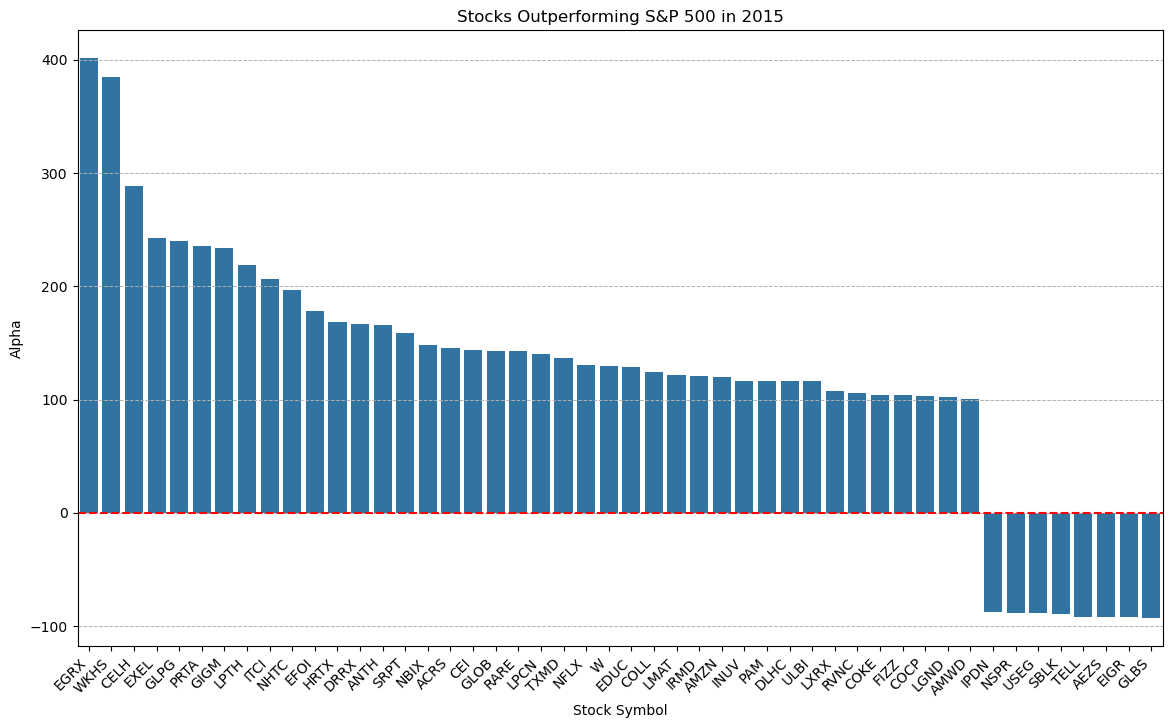

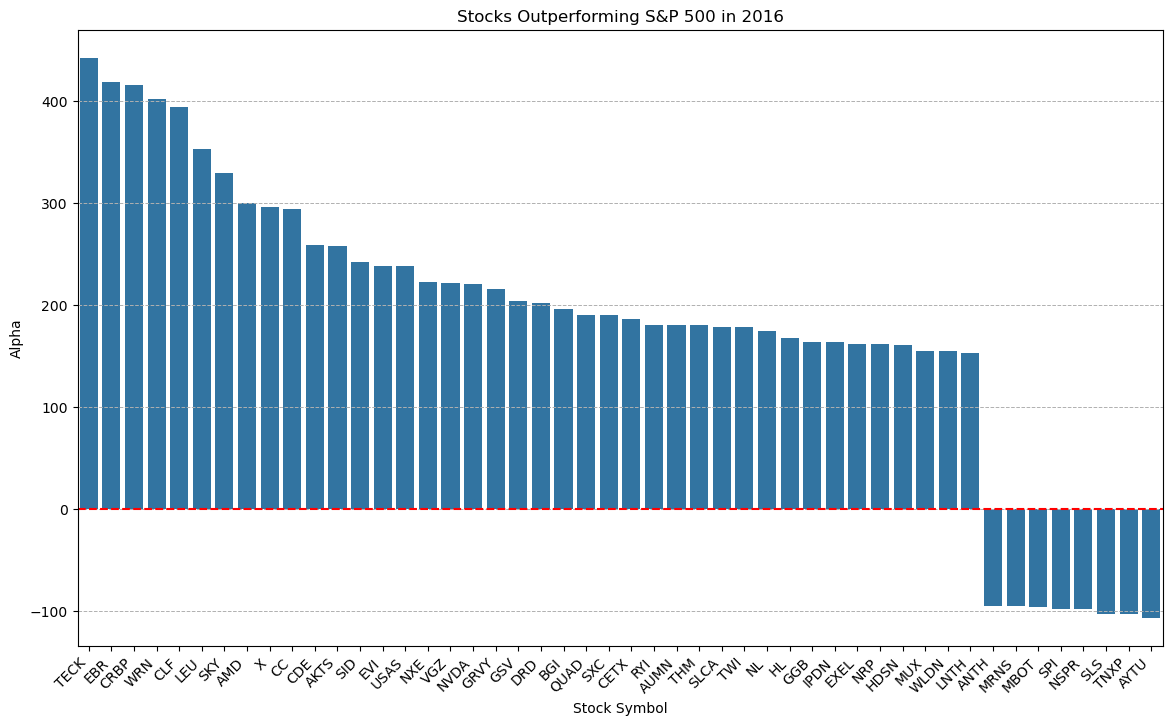

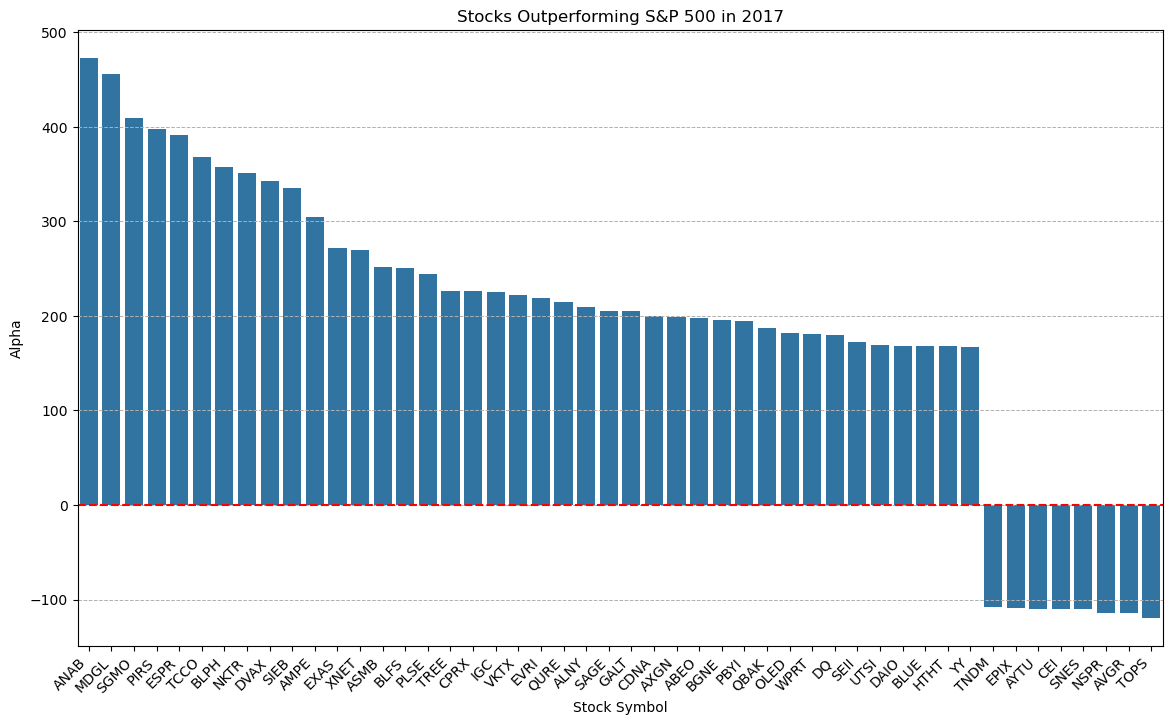

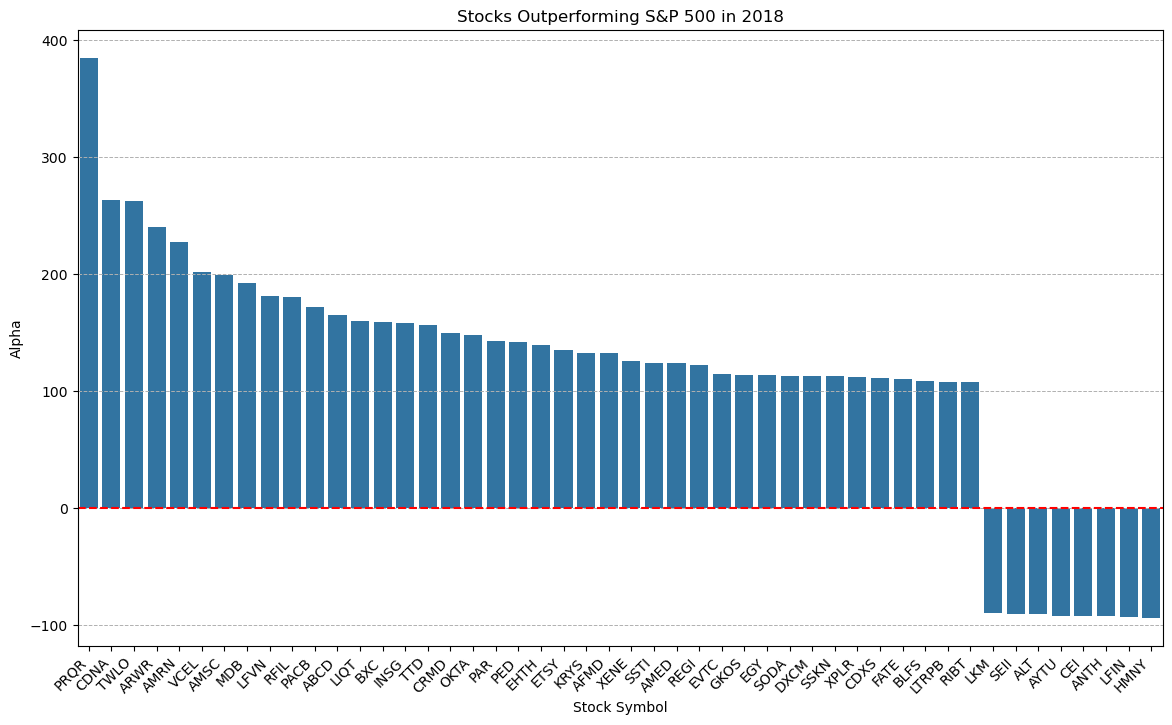

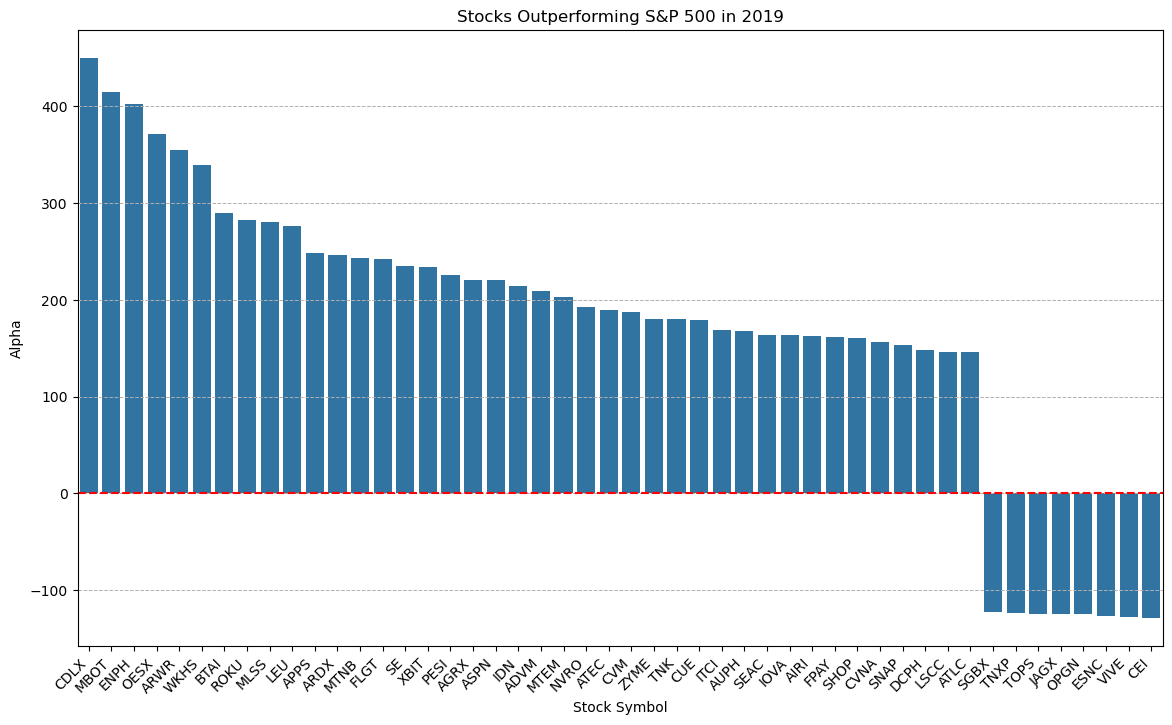

In [75]:
# Plot alphas for each year with default top 10 and bottom 10
top_n = 40
bottom_n = 8

plot_alphas(data_2014, 2015, top_n=top_n, bottom_n=bottom_n)
plot_alphas(data_2015, 2016, top_n=top_n, bottom_n=bottom_n)
plot_alphas(data_2016, 2017, top_n=top_n, bottom_n=bottom_n)
plot_alphas(data_2017, 2018, top_n=top_n, bottom_n=bottom_n)
plot_alphas(data_2018, 2019, top_n=top_n, bottom_n=bottom_n)

#### Just for curiosity let's see how many stocks outperform the S&P500 in the year of study

In [76]:
data_2014[data_2014['2015 PRICE VAR [%]']>0].shape[0]

1570

In [77]:
data_2015[data_2015['2016 PRICE VAR [%]']>0].shape[0]

2833

In [78]:
data_2016[data_2016['2017 PRICE VAR [%]']>0].shape[0]

3150

In [79]:
data_2017[data_2017['2018 PRICE VAR [%]']>0].shape[0]

1325

In [80]:
data_2018[data_2018['2019 PRICE VAR [%]']>0].shape[0]

2992

In [81]:
for c in data_2014.columns:
    print(c)

Revenue
Revenue Growth
Cost of Revenue
Gross Profit
R&D Expenses
SG&A Expense
Operating Expenses
Operating Income
Interest Expense
Earnings before Tax
Income Tax Expense
Net Income - Non-Controlling int
Net Income - Discontinued ops
Net Income
Preferred Dividends
Net Income Com
EPS
EPS Diluted
Weighted Average Shs Out
Weighted Average Shs Out (Dil)
Dividend per Share
Gross Margin
EBITDA Margin
EBIT Margin
Profit Margin
Free Cash Flow margin
EBITDA
EBIT
Consolidated Income
Earnings Before Tax Margin
Net Profit Margin
Cash and cash equivalents
Cash and short-term investments
Receivables
Inventories
Total current assets
Property, Plant & Equipment Net
Goodwill and Intangible Assets
Tax assets
Total assets
Payables
Total current liabilities
Long-term debt
Total debt
Deferred revenue
Tax Liabilities
Deposit Liabilities
Total liabilities
Other comprehensive income
Retained earnings (deficit)
Total shareholders equity
Investments
Other Assets
Other Liabilities
Depreciation & Amortization
Stoc

Let's change the column name 2014 price var and alpha_2014 for something that contain all the datasets

In [82]:
datasets = [data_2014, data_2015, data_2016, data_2017, data_2018]

# Rename columns dynamically based on the year
for i, df in enumerate(datasets):
    year = 2014 + i
    df.rename(columns={f'{year + 1} PRICE VAR [%]': 'PRICE VAR [%]', f'Alpha_{year + 1}': 'Alpha'}, inplace=True)
    
data_2015.columns

Index(['Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense', 'Earnings before Tax',
       ...
       'Book Value per Share Growth', 'Debt Growth', 'R&D Expense Growth',
       'SG&A Expenses Growth', 'PRICE VAR [%]', 'Class', 'Year', 'Symbol',
       'Sector', 'Alpha'],
      dtype='object', length=207)

Looks good!

### Now let's create binary dependent variables:

1. Creates a new column Alpha_gt_3 where the value is 1 if Alpha is greater than 3% (0.03), and 0 otherwise.

2. Creates a new column Alpha_gt_minus5 where the value is 1 if Alpha is greater than -5% (-0.05), and 0 otherwise.
 
3. Creates a new column Alpha_gt_10 where the value is 1 if Alpha is greater than 10% (0.10), and 0 otherwise.

In [83]:
def create_binary_variables(df):
    df['Alpha_gt_3'] = df['Alpha'].apply(lambda x: 1 if x > 0.03 else 0)
    df['Alpha_gt_5'] = df['Alpha'].apply(lambda x: 1 if x > 0.05 else 0)
    df['Alpha_gt_10'] = df['Alpha'].apply(lambda x: 1 if x > 0.10 else 0)
    return df

updated_datasets = [create_binary_variables(df) for df in datasets]

In [87]:
data_2014.Alpha_gt_3.dtype

dtype('int64')

# 2. Dummie variables, Scaling and dataset split

In [85]:
# Combine datasets for processing
combined_data = pd.concat(datasets).reset_index(drop=True)

# Create dummy features for the 'Sector' column
combined_data = pd.get_dummies(combined_data, columns=['Sector'], drop_first=True)

# Separate features and target variable
features = combined_data.drop(columns=['Alpha', 'Symbol'])
target = combined_data['Alpha']

# Standardize numeric features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert back to DataFrame
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# Add the target column back to the scaled features DataFrame
features_scaled_df['Alpha'] = target.reset_index(drop=True)

# Reset indices to ensure alignment for boolean indexing
features_scaled_df = features_scaled_df.reset_index(drop=True)
combined_data = combined_data.reset_index(drop=True)

# Split the data into training (2014-2016), validation (2017), and test (2018) sets
train_data = features_scaled_df[combined_data['Year'].isin([2014, 2015, 2016])]
validation_data = features_scaled_df[combined_data['Year'] == 2017]
test_data = features_scaled_df[combined_data['Year'] == 2018]

# Check if any of the splits are empty
print("Training set shape:", train_data.shape)
print("Validation set shape:", validation_data.shape)
print("Test set shape:", test_data.shape)

# Extract features and target for each set
X_train = train_data.drop(columns=['Alpha'])
y_train = train_data['Alpha']

X_validation = validation_data.drop(columns=['Alpha'])
y_validation = validation_data['Alpha']

X_test = test_data.drop(columns=['Alpha'])
y_test = test_data['Alpha']

# Ensure splits are not empty before standardizing
if not X_train.empty and not X_validation.empty and not X_test.empty:
    # Standardize the training, validation, and test features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)
    X_test_scaled = scaler.transform(X_test)

    # Print shapes to verify
    print("Training set shape after scaling:", X_train_scaled.shape)
    print("Validation set shape after scaling:", X_validation_scaled.shape)
    print("Test set shape after scaling:", X_test_scaled.shape)
else:
    print("One of the data splits is empty. Please check the data.")

Training set shape: (12352, 218)
Validation set shape: (4838, 218)
Test set shape: (4263, 218)
Training set shape after scaling: (12352, 217)
Validation set shape after scaling: (4838, 217)
Test set shape after scaling: (4263, 217)


In [86]:
# Save the training, validation, and test datasets
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_validation_scaled_df = pd.DataFrame(X_validation_scaled, columns=X_validation.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Add the target variable back to each set
X_train_scaled_df['Alpha'] = y_train.reset_index(drop=True)
X_validation_scaled_df['Alpha'] = y_validation.reset_index(drop=True)
X_test_scaled_df['Alpha'] = y_test.reset_index(drop=True)

# Save to CSV
X_train_scaled_df.to_csv('training_testing_validation_data/training_set.csv', index=False)
X_validation_scaled_df.to_csv('training_testing_validation_data/validation_set.csv', index=False)
X_test_scaled_df.to_csv('training_testing_validation_data/test_set.csv', index=False)

print("Datasets saved successfully.")


Datasets saved successfully.
